# Trying lightfm 

In [9]:
from lightfm import LightFM

from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_seq_items = 10000
from src.test_ranking import *

%reload_ext autoreload

In [4]:
# Function to get from mongo collection to pandas df

df = clean_up_mongo_coll(db.main_redo)

In [5]:
user_song = turn_df_to_util_mat(
    df, 'new_song_producer', 'sampled_artist_song')

In [6]:
# LightFM asks for a user_id sparse matrix, with 1s
# denoting positive interactions and -1 denoting negative. 

# so we change all actual interactions to 1.
new = user_song[user_song > 0] == 1

new = new.astype(int)

new2 = csr_matrix(new.values)

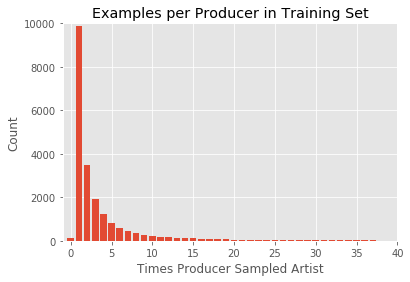

In [122]:
samples_per_prod = new.sum(axis = 1)
counts = samples_per_prod.value_counts().sort_index()

fig, ax = plt.subplots()
ax.set(ylim = (0,10000), xlim = (-1, 40), 
       title = "Examples per Producer in Training Set",
       xlabel = "Times Producer Sampled Artist", 
       ylabel = "Count")
# ax.axvline(5, color ='black')
_ = ax.bar(counts.index, counts.values)

In [383]:
from lightfm import cross_validation
train, test = cross_validation.random_train_test_split(new2, test_percentage= 0.1)

In [384]:
print(repr(new2))
print(repr(train))
print(repr(test))

<21379x33719 sparse matrix of type '<class 'numpy.int64'>'
	with 126369 stored elements in Compressed Sparse Row format>
<21379x33719 sparse matrix of type '<class 'numpy.int64'>'
	with 113732 stored elements in COOrdinate format>
<21379x33719 sparse matrix of type '<class 'numpy.int64'>'
	with 12637 stored elements in COOrdinate format>


In my test set, all the users are present, but only 8978 have at least 1 interaction. 

I'm confused. Why are there no 0.5s in the test_auc. Maybe it's the preserve_rows parameter. 

So user 0 has nothing to predict, so he gets a 0.5

User 0 has 11 interactions in the train set, but none in the test set.

So we learn about him from 11 interactions, but there is nothing left to predict. 

User 1 has 1 interaction we are trying to predict, but he has nothing in the train set.

User 50 has 21 interactions in the test set, from 77 he is trained on. This makes sense, it's 2 Live Crew, who has 98 total samples. 

User 2460 has 70 in train, 21 in test, 91 in total- it's bronze nazareth. 

It would be better if we could do it per user. 

In [323]:
# Trying to filter train and test so that 
# we only have entries where there's at least one
# training example and one test interaction to predict. 
train_d = train.todense()
test_d = test.todense()

# Count how many interactions in the train set
train_sums = train.sum(axis = 1)>0

# this is a weird nested matrix, here's the hack to get it to a list
train_sums = np.array([train_sums[i,0] for i in range(train_sums.shape[0])])

#Furthermore, we only want to test precision/ recall for users who we actu
#ally have something to predict, i.e., there's something in the test set.

#do same for test.
test_sums = test_d.sum(axis = 1)>0

test_sums = np.array([test_sums[i,0] for i in range(test_sums.shape[0])])

# finally we can filter the training set 
#so that it has at least 1 example to train on.
train_d = train_d[(train_sums) & (test_sums)]

test_d = test_d[(train_sums) & (test_sums)]

train = csr_matrix(train_d)
test = csr_matrix(test_d)

## Details of LightFM

There are 4 types of losses the model can use. By default it uses Logistic, but it says this is more useful when negative interactions are present. 

My test precision, using logistic loss, and removing train interactions, is 0.01. The AUC is 0.91 on the training data.

Changing the loss to WARP doesn't help the precision. Increasing the number of factors lowers it/ 

warp with 40 components has a .81 test auc, compared to .63 for bpr

In [385]:
model = LightFM(loss='warp', no_components= 40)
model.fit(train, epochs=30)

In [291]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model, train).mean()
print('Train AUC: %s' % train_auc)

Train AUC: 0.9995029


In [386]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model, test, train, preserve_rows=True)
print('Test AUC: %s' % test_auc.mean())

Test AUC: 0.5842495


In [387]:
from lightfm import evaluation
mean_p = evaluation.precision_at_k(model, test, train, preserve_rows= True)

In [388]:
mean_p.mean()

0.0033444033

In [389]:
mean_p[:100]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32)

In [419]:
test

<21379x33719 sparse matrix of type '<class 'numpy.int64'>'
	with 12637 stored elements in COOrdinate format>

In [390]:
recall_train = evaluation.recall_at_k(model, test, train)

In [420]:
from lightfm import data

In [ ]:
data.Dataset()

In [391]:
np.mean(recall_train)

0.07855215870824425

In [379]:
np.array([[0,2],[0,4]])

array([[0, 2],
       [0, 4]])

In [401]:
list(new.index).index("J Dilla")

9117

In [ ]:
model.predict()

In [418]:
len(np.array([[0,1],[2,1]]))

2

In [423]:
# Trying to understand the dataset class
model.user_embeddings.shape

(21379, 40)

In [417]:
model.predict([9117, 897], [[0,1],[2,1]])

AssertionError: 

In [360]:
yooo = yoo.todense()

In [363]:
yooo[:100,:100]

matrix([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         

Filtering cold start problems, gets our precision up to 0.0159

In [ ]:
def sample_recommendation(model, new, user_ids):


    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:3]:
            print("        %s" % x)

sample_recommendation(model, data, [3, 25, 450])

In [324]:
train.sum(axis = 1)

matrix([[ 10],
        [  3],
        [  9],
        [  4],
        [  7],
        [  4],
        [  1],
        [ 13],
        [  3],
        [  5],
        [ 23],
        [ 11],
        [ 18],
        [  5],
        [  1],
        [  3],
        [  4],
        [  5],
        [  5],
        [ 77],
        [  4],
        [  3],
        [  3],
        [  3],
        [ 20],
        [  1],
        [  4],
        [ 27],
        [ 16],
        [  7],
        [  1],
        [ 27],
        [ 13],
        [  6],
        [  4],
        [ 85],
        [  5],
        [  3],
        [  1],
        [  8],
        [ 66],
        [  6],
        [ 20],
        [  2],
        [ 32],
        [  2],
        [ 11],
        [  6],
        [  2],
        [ 14],
        [  1],
        [  9],
        [  5],
        [ 45],
        [  8],
        [  2],
        [  6],
        [724],
        [  4],
        [  2],
        [  3],
        [ 11],
        [  8],
        [  7],
        [130],
        [  8],
        [ 